In [77]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
df = pd.read_csv('Gia SMP va SMPcap 2021(Giá thị trường SMP).csv')
df.head(5)

,Ngay,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [79]:
feats = ['8', '9']

In [80]:
df[feats].head()

,8,9
0,964.4,964.4
1,1019.7,1019.7
2,988.4,988.4
3,1002.0,1002.1
4,1061.5,1061.5


In [81]:
df[feats].isna().mean()

8    0.0
9    0.0
dtype: float64

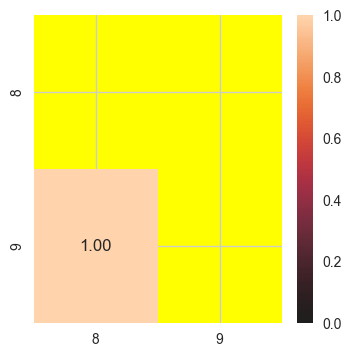

In [82]:
mask = np.triu(np.ones_like(df[feats].corr(), dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(4,4))
sns.heatmap(df[feats].corr(), mask=mask, vmax=1, vmin=0, center=0,annot=True,fmt='.2f');

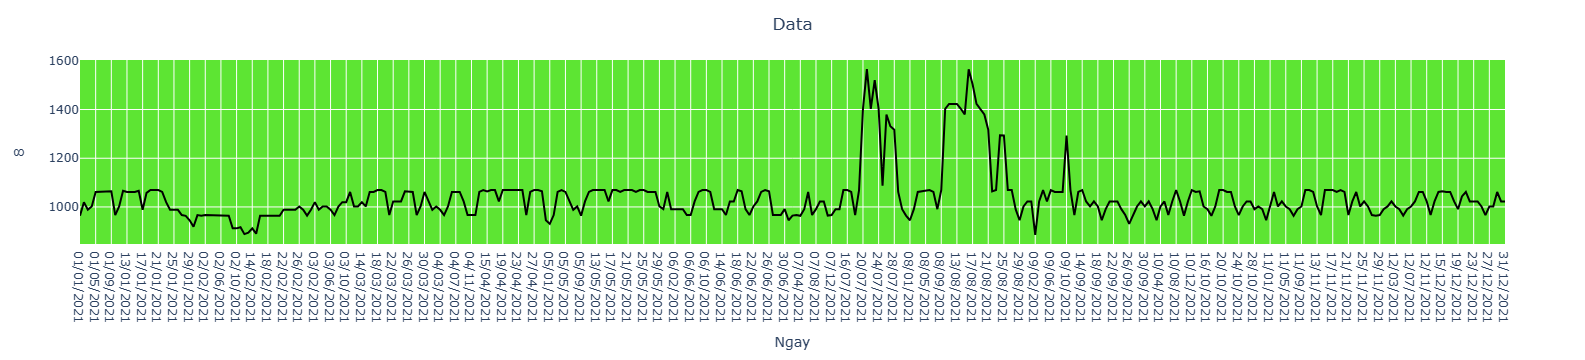

In [83]:
import plotly.express as px
fig = px.line(y=df['8'], x=df['Ngay'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Ngay", 
                  yaxis_title="8",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

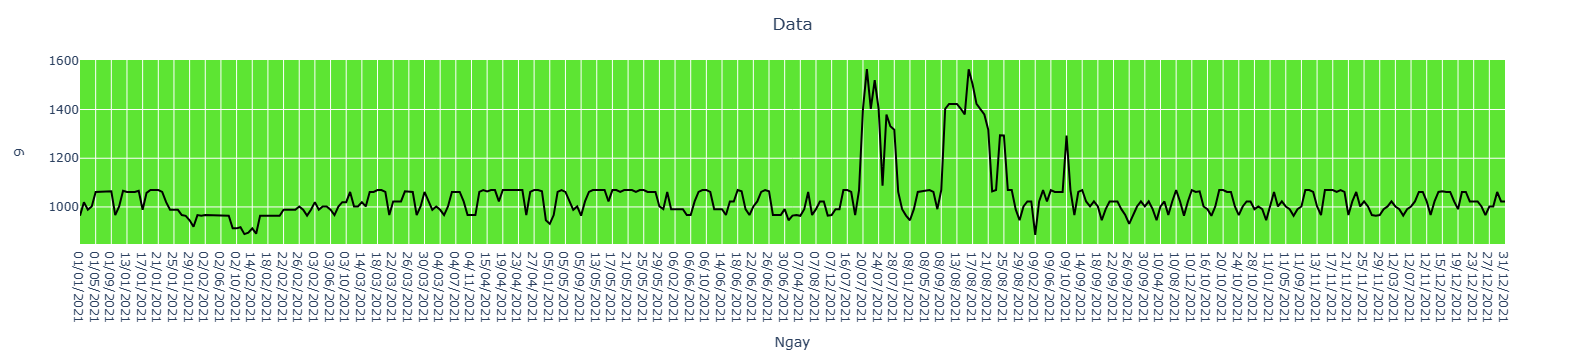

In [84]:
fig = px.line(y=df['9'], x=df['Ngay'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Ngay", 
                  yaxis_title="9",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

In [85]:
transformer = StandardScaler()
X = transformer.fit_transform(np.array(df[feats]))

In [86]:
X[:5]

array([[-0.7221531 , -0.7225876 ],
       [-0.19550132, -0.19596525],
       [-0.49358813, -0.49403541],
       [-0.36406799, -0.36357019],
       [ 0.20258266,  0.2020965 ]])

C:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

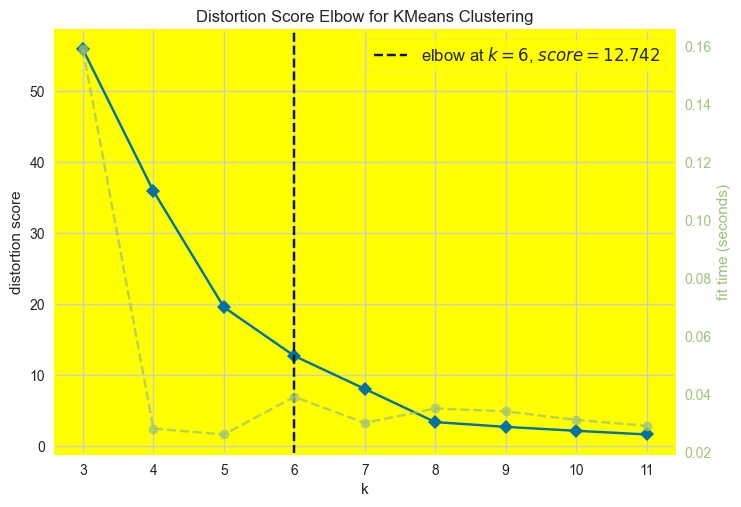

In [87]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

Elbow_M = KElbowVisualizer(KMeans(random_state=23), k=(3,12))
Elbow_M.fit(X)
Elbow_M.show();

In [88]:
BGM = BayesianGaussianMixture(n_components=6,covariance_type='full',random_state=1,n_init=12)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [89]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(6)]]=pp 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(6):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.5)].index
    train_index = np.concatenate((train_index, n_inx))

In [90]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(5)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

C:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[200]	valid_0's multi_logloss: 0.00542853
[200]	valid_0's multi_logloss: 0.00246459
[200]	valid_0's multi_logloss: 0.00311854
[200]	valid_0's multi_logloss: 0.00131357
[400]	valid_0's multi_logloss: 0.00131357
[200]	valid_0's multi_logloss: 0.494771


In [91]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [92]:
labels=np.argmax(lgb_preds,axis=1)

In [93]:
u = np.unique(labels)
u

array([0, 1, 5], dtype=int64)

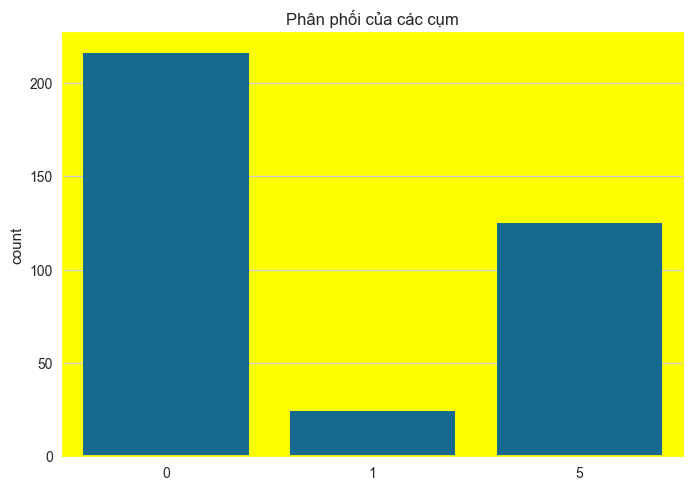

In [94]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Phân phối của các cụm")
plt.show()

In [95]:
BGM = BayesianGaussianMixture(n_components=4,covariance_type='full',random_state=1,n_init=12)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [96]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(4)]]=pp 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(4):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.5)].index
    train_index = np.concatenate((train_index, n_inx))

In [97]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(5)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

C:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[200]	valid_0's multi_logloss: 0.00275981
[200]	valid_0's multi_logloss: 0.00505691
[200]	valid_0's multi_logloss: 0.00285742
[400]	valid_0's multi_logloss: 0.00285742
[200]	valid_0's multi_logloss: 0.00283209
[200]	valid_0's multi_logloss: 0.495131


In [98]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])
labels=np.argmax(lgb_preds,axis=1)

In [99]:
u = np.unique(labels)
u

array([0, 1], dtype=int64)

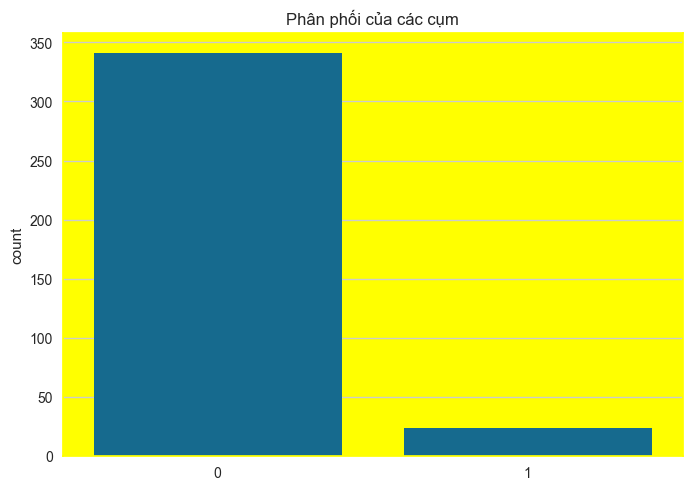

In [100]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Phân phối của các cụm")
plt.show()

In [101]:
BGM = BayesianGaussianMixture(n_components=3,covariance_type='full',random_state=1,n_init=12)
preds = BGM.fit_predict(X)
df["Clusters"]= preds

In [102]:
pp=BGM.predict_proba(X)
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(3)]]=pp 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(3):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.5)].index
    train_index = np.concatenate((train_index, n_inx))

In [103]:
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(5)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

C:\Users\WELCOME\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



[200]	valid_0's multi_logloss: 0.00275981
[200]	valid_0's multi_logloss: 0.00505691
[200]	valid_0's multi_logloss: 0.00285742
[400]	valid_0's multi_logloss: 0.00285742
[200]	valid_0's multi_logloss: 0.00283209
[200]	valid_0's multi_logloss: 0.495131


In [104]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])
labels=np.argmax(lgb_preds,axis=1)

In [105]:
u = np.unique(labels)
u

array([0, 1], dtype=int64)

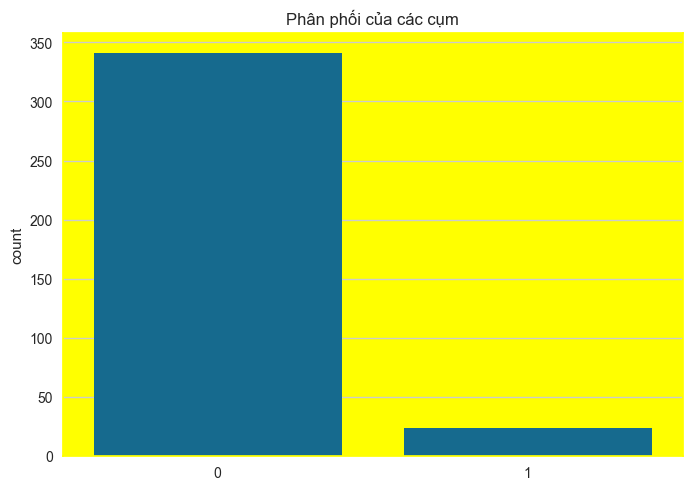

In [106]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Phân phối của các cụm")
plt.show()

In [107]:
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import GRU

In [108]:
feats = ['Ngay', '8', '9']

In [109]:
df = df[feats]

In [110]:
df

,Ngay,8,9
0,01/01/2021,964.4,964.4
1,01/02/2021,1019.7,1019.7
2,01/03/2021,988.4,988.4
3,01/04/2021,1002.0,1002.1
4,01/05/2021,1061.5,1061.5
...,...,...,...
360,27/12/2021,1002.0,1002.0
361,28/12/2021,1002.0,1002.0
362,29/12/2021,1061.5,1061.5
363,30/12/2021,1022.6,1022.6


In [111]:
df['Ngay'] = pd.to_datetime(df['Ngay'], format='%d/%m/%Y')
df.sort_values(by='Ngay', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [112]:
test_size = df[df['Ngay'].dt.month==12].shape[0]
test_size

31

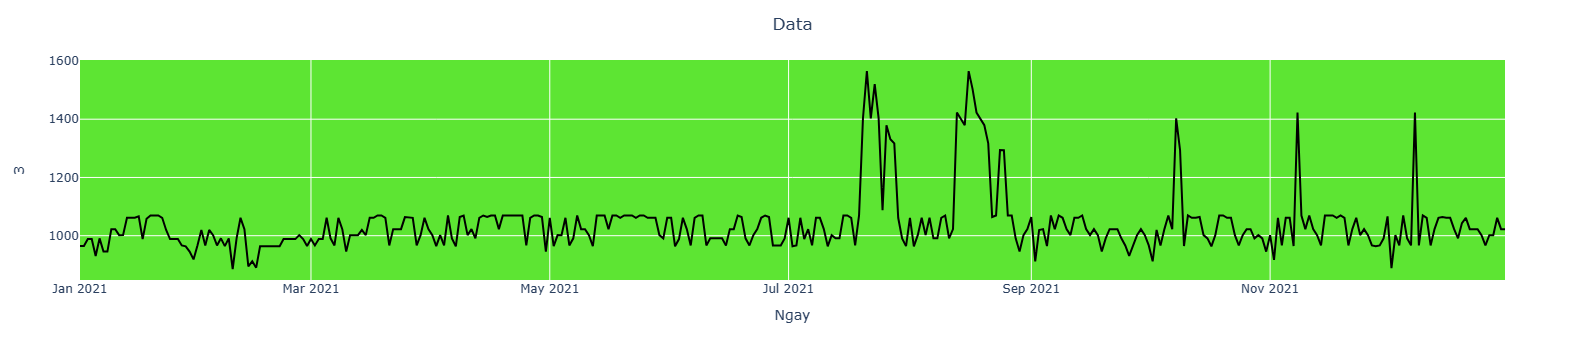

In [113]:
import plotly.express as px
fig = px.line(y=df['8'], x=df['Ngay'])
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Ngay", 
                  yaxis_title="3",
                  title={'text': "Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(53,223,0,0.8)')

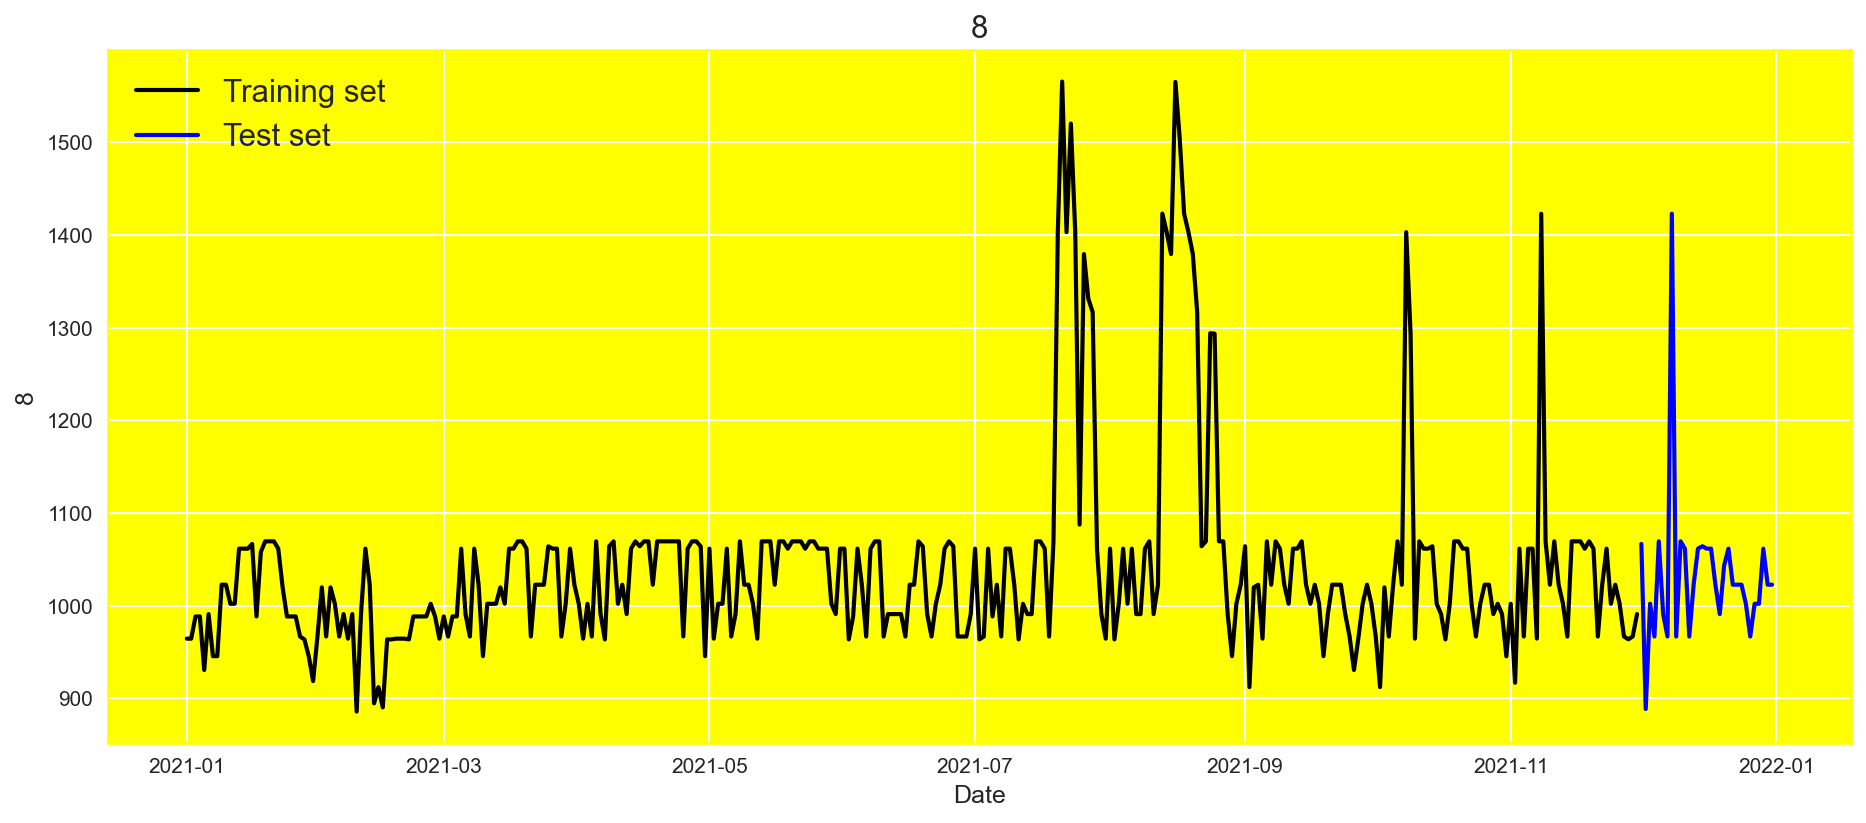

In [114]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='yellow')
plt.plot(df['Ngay'][:-test_size], df['8'][:-test_size], color='black', lw=2)
plt.plot(df['Ngay'][-test_size:], df['8'][-test_size:], color='blue', lw=2)
plt.title('8', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('8', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [116]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['8']])

MinMaxScaler()

In [117]:
window_size = 10

In [118]:
train_data = df[['8']][:-test_size]
train_data = scaler.transform(train_data)

In [119]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

In [120]:
test_data = df[['8']][-test_size-window_size:]
test_data = scaler.transform(test_data)

In [121]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [122]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [123]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [124]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (324, 10, 1)
y_train Shape:  (324, 1)
X_test Shape:   (31, 10, 1)
y_test Shape:   (31, 1)


In [125]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = GRU(units = 64, return_sequences=False)(input1)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [126]:
model = define_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,977 (58.50 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0534 - val_loss: 0.0366
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0570 - val_loss: 0.0280
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0331 - val_loss: 0.0149
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - val_loss: 0.0157
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - val_loss: 0.0148
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0264 - val_loss: 0.0149
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0200 - val_loss: 0.0151
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0230 - val_loss: 0.0153
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0202 - val_loss: 0.0151
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 - val_loss: 0.0150
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0204 - val_loss: 0.0157
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157 - val_l

In [127]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


In [128]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(y_test, y_pred)

In [129]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)

Test Loss: 0.018314993008971214
Test MAPE: 1.8694586624761358


In [130]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

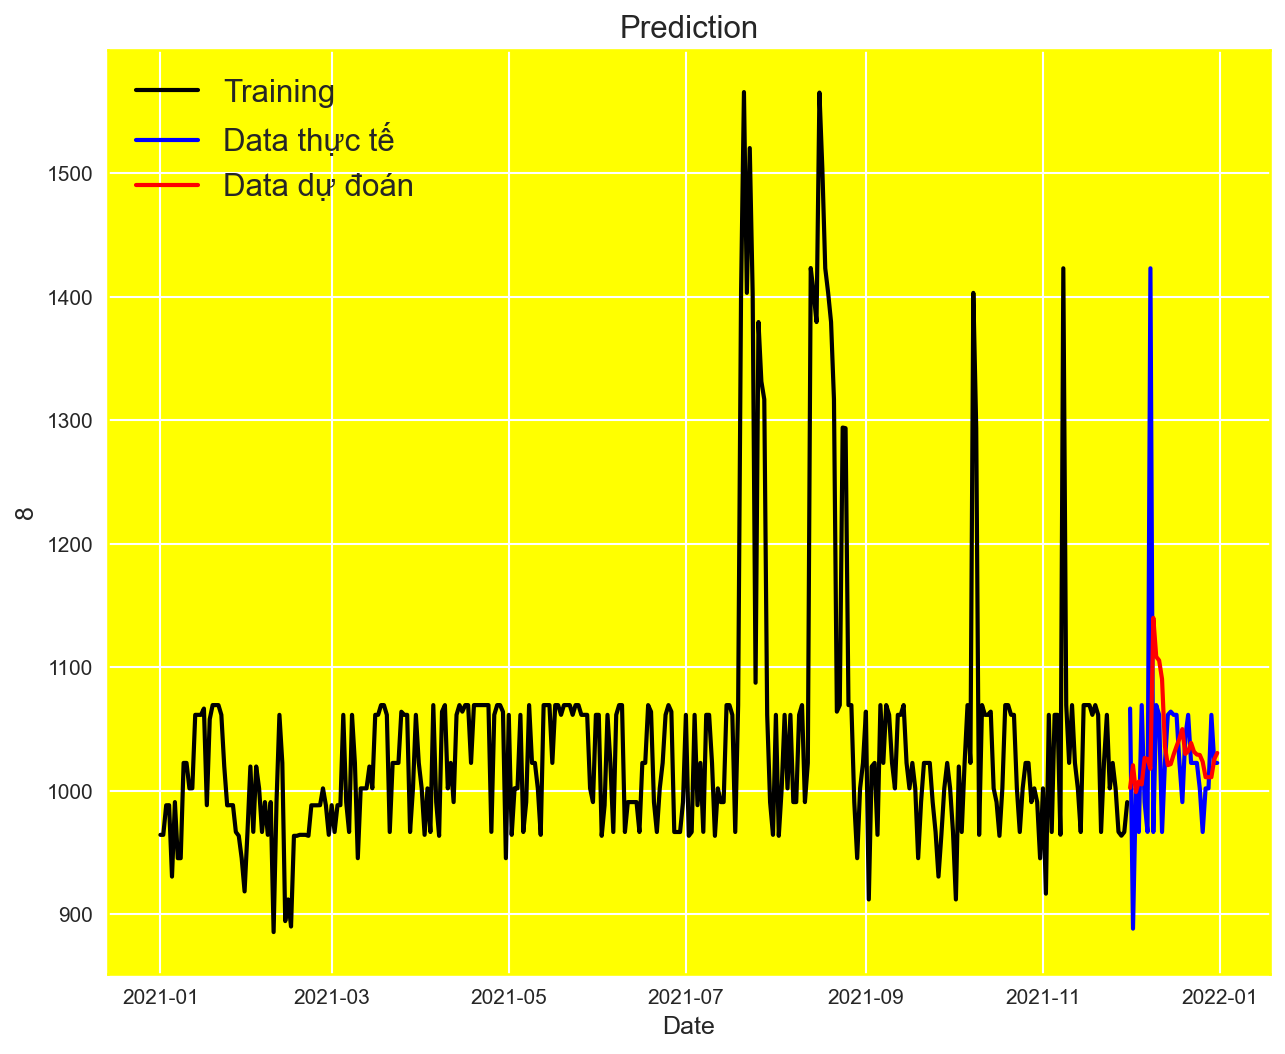

In [131]:
plt.figure(figsize=(10, 8), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='yellow')
plt.plot(df['Ngay'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Ngay'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Ngay'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('8', fontsize=12)
plt.legend(['Training', 'Data thực tế', 'Data dự đoán'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()